In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
df = pd.read_csv("data/interim/aita_scrapped_full.csv", index_col=0)
sort = df[["verdict", "title"]].groupby("verdict").count()
sort = sort.sort_values(by=["title"], ascending=False).reset_index()
sort = sort[sort["title"] > 10]
print(sort["verdict"].tolist())

['Not the A-hole', 'Asshole', 'No A-holes here', 'Everyone Sucks', 'not the a-hole', 'Not enough info', 'asshole', 'UPDATE', 'Update', 'META', 'everyone sucks', 'no a--holes here', 'not enough info']


In [3]:
def pp_mapverdict(df):
    df["target"] = df["verdict"].map(
        lambda y: "NTA"
        if y in ["Not the A-hole", "not the a-hole"]
        else "YTA"
        if y in ["Asshole", "asshole"]
        else "NAH"
        if y in ["No A-holes here", "no a--holes here"]
        else "ESH"
        if y in ["Everyone Sucks", "everyone sucks"]
        else "n/a"
    )
    df = df[df["target"] != "n/a"]
    return df

df_verdict = pp_mapverdict(df)
df_verdict[["target", "title"]].groupby("target").count()

,title
target,
ESH,1379
NAH,2630
NTA,18842
YTA,5564


In [4]:
def pp_minbodylength(df):
    length_body = []
    for text in df["body"]:
        length = len(str(text))
        length_body.append(length)
    df["length_body"] = length_body
    df = df[(df["length_body"] >= 100) & (df["length_body"] <= 3500)]
    return df
print(len(df_verdict))
df_minlen = pp_minbodylength(df_verdict)
print(len(df_minlen))
df_minlen.sort_values(by=["length_body"]).head()

28415
22498


,verdict,body,num_comments,score,upvote_ratio,title,id,date,target,length_body
29445,not the a-hole,Rundown and shabby neighbourhoods get nice bus...,68,77,0.84,AITA for liking gentrification?,81dulc,2018-03-02 12:26:23,NTA,100
26804,Not the A-hole,"I didn't, but only because my friends convince...",91,84,0.90,AITA for wanting to order delivery in a blizzard,b11xp9,2019-03-14 15:51:55,NTA,109
27600,Not the A-hole,Over 600 pics...it was fun. 🤦🏻‍♂️\n\nEDIT: The...,236,315,0.89,AITA for photoshopping the hair of one of my w...,awzuvd,2019-03-03 23:07:32,NTA,116
25048,No A-holes here,"I mean, it’s not like I’m trying to compliment...",152,929,0.95,AITA for being annoyed that my bf says “thank ...,b91txn,2019-04-03 18:38:21,NAH,124
29088,asshole,I can't really articulate why but I find it ve...,93,43,0.71,AITA for not showing my receipt at Walmart?,8ofpls,2018-06-04 08:32:54,YTA,126


In [5]:
df_minlen[["target", "title"]].groupby("target").count()

,title
target,
ESH,1045
NAH,2072
NTA,15013
YTA,4368


In [6]:
def pp_titlecheck(df):
    type_list = []
    for aita in df["title"]:
        title_aita = list(aita.split(" "))[0]
        title_aita = (" ".join(re.findall("[a-zA-Z]+", title_aita))).lower()

        aita_check = bool(re.match(title_aita, "aita"))
        wibta_check = bool(re.match(title_aita, "wibta"))

        if aita_check:
            type_list.append("AITA")
        elif wibta_check:
            type_list.append("WIBTA")
        else:
            type_list.append("n/a")

    df["title_aita"] = type_list
    return df

df_title = pp_titlecheck(df_minlen)
df_title[["title_aita", "title"]].groupby("title_aita").count()

,title
title_aita,
AITA,19146
WIBTA,3221
n/a,131


In [7]:
df2 = df_title.copy()

def density_plot_var_target(variables, target, df2):
    df2 = df2[df2["title_aita"] != "n/a"]
    count = 0
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    for variable in variables:
        if variable not in ["length_body", "upvote_ratio"]:
            df2[variable] = np.log(df2[variable])
        for name in list(df2[target].unique()):
            g=sns.kdeplot(
                df2[variable][(df2[target] == name)],
                legend=True,
                shade=True,
                ax=ax[count]
            )
        if variable not in ["length_body", "upvote_ratio"]:
            g.title.set_text(("log %s"%variable))
        else:
            g.title.set_text(variable)
        g.set_xlim(left=0)
        g.legend(list(df2[target].unique()))
        count += 1

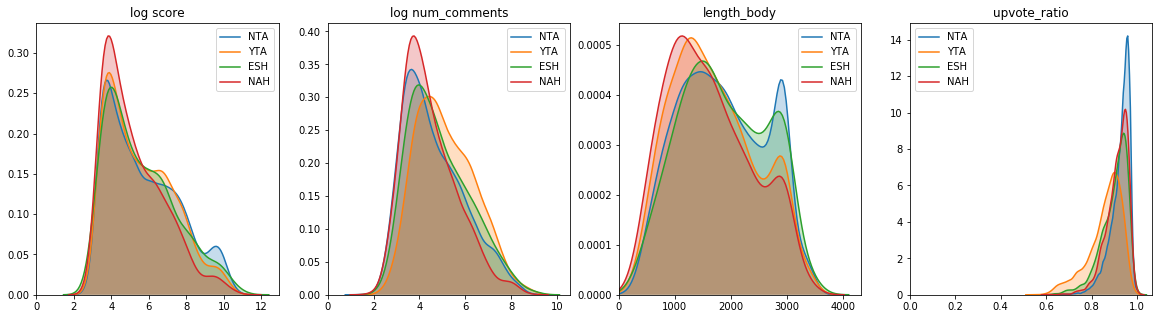

In [8]:
density_plot_var_target(["score", "num_comments", "length_body", "upvote_ratio"], "target", df2)

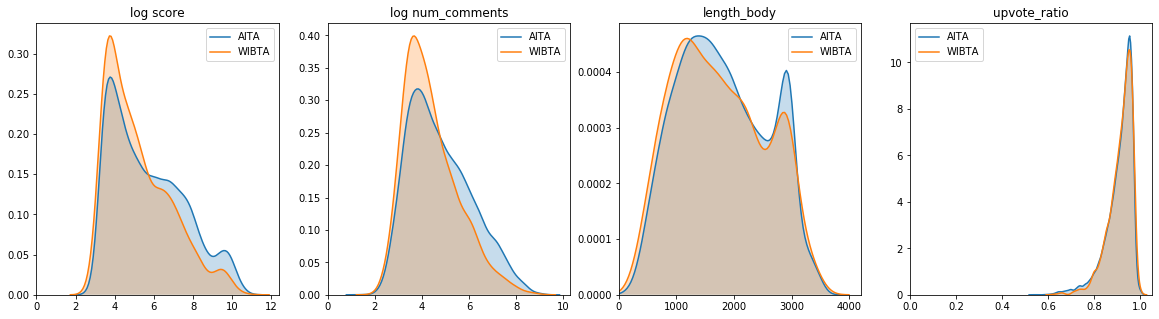

In [9]:
density_plot_var_target(["score", "num_comments", "length_body", "upvote_ratio"], "title_aita", df2)

In [10]:
aita = pd.read_csv("data/interim/aita_scrapped_full.csv", index_col=0)

def pp_analysis(df):
    df = pp_mapverdict(df)
    df = pp_minbodylength(df)
    df = pp_titlecheck(df)
    df = df.reset_index(drop=True)
    return df

aita = pp_analysis(aita)
print(aita.shape)
aita.to_csv("data/processed/aita_cleaned_full.csv")
aita.head()

(22498, 11)


,verdict,body,num_comments,score,upvote_ratio,title,id,date,target,length_body,title_aita
0,Not the A-hole,"I have a house I rent, and some of my neighbor...",324,4097,0.97,AITA for renting a house and telling my neighb...,g637y9,2020-04-22 15:31:14,NTA,1206,AITA
1,Not the A-hole,tl;dr: i have large breasts that have caused m...,1089,19436,0.90,AITA my boyfriend wont let me get a breast red...,g5n4a3,2020-04-21 20:35:11,NTA,2023,AITA
2,Not the A-hole,"I got in trouble at school this fall, I'm a ju...",2876,26316,0.93,AITA? My parents took most of my wardrobe away...,g5hta8,2020-04-21 15:56:36,NTA,2031,AITA
3,Asshole,I'll try to make this short. I'm (38m) and my ...,805,3845,0.91,AITA for going on a week long vacation by myse...,g3y0xe,2020-04-19 00:11:52,YTA,871,AITA
4,Not the A-hole,"I'm a senior broadcast producer, and our manag...",151,1016,0.96,"WIBTA If I ""warned"" my current coworkers about...",g3xvzw,2020-04-19 00:02:19,NTA,1898,WIBTA


In [11]:
aita[["target", "title"]].groupby("target").count()

,title
target,
ESH,1045
NAH,2072
NTA,15013
YTA,4368


In [12]:
def pp_for_model(df):
    df["binary_target"] = df["target"].map(
        lambda y: 1
        if y in ["ESH", "YTA"]
        else 0
        if y in ["NAH", "NTA"]
        else "n/a"
    )
    df = df[["target", "binary_target", "title", "body"]]
    return df

df_xy = pp_for_model(df_title)
df_xy[["binary_target", "title"]].groupby("binary_target").count()

,title
binary_target,
0,17085
1,5413


In [13]:
aita = pd.read_csv("data/interim/aita_scrapped_full.csv", index_col=0)

def pp_analysis(df):
    df = pp_mapverdict(df)
    df = pp_minbodylength(df)
    df = pp_titlecheck(df)
    df = pp_for_model(df)
    df = df.reset_index(drop=True)
    return df

aita = pp_analysis(aita)
print(aita.shape)
aita.to_csv("data/processed/aita_xy_cleaned_full.csv")
aita.head()

(22498, 4)


,target,binary_target,title,body
0,NTA,0,AITA for renting a house and telling my neighb...,"I have a house I rent, and some of my neighbor..."
1,NTA,0,AITA my boyfriend wont let me get a breast red...,tl;dr: i have large breasts that have caused m...
2,NTA,0,AITA? My parents took most of my wardrobe away...,"I got in trouble at school this fall, I'm a ju..."
3,YTA,1,AITA for going on a week long vacation by myse...,I'll try to make this short. I'm (38m) and my ...
4,NTA,0,"WIBTA If I ""warned"" my current coworkers about...","I'm a senior broadcast producer, and our manag..."


In [21]:
nta_yta = aita.loc[aita['target'].isin(["NTA", "YTA"])]
print(nta_yta.shape)
nta_yta.to_csv("data/processed/aita_xy_cleaned_full_nta_yta.csv")
nta_yta.head()

(19381, 4)


,target,binary_target,title,body
0,NTA,0,AITA for renting a house and telling my neighb...,"I have a house I rent, and some of my neighbor..."
1,NTA,0,AITA my boyfriend wont let me get a breast red...,tl;dr: i have large breasts that have caused m...
2,NTA,0,AITA? My parents took most of my wardrobe away...,"I got in trouble at school this fall, I'm a ju..."
3,YTA,1,AITA for going on a week long vacation by myse...,I'll try to make this short. I'm (38m) and my ...
4,NTA,0,"WIBTA If I ""warned"" my current coworkers about...","I'm a senior broadcast producer, and our manag..."
